# Initialization

In [1]:
!git clone https://github.com/RoyHirsch/DLA.git
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

fatal: destination path 'DLA' already exists and is not an empty directory.


In [4]:
from IPython.display import Image, display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



# Capture your image

<IPython.core.display.Javascript object>

The captured photo


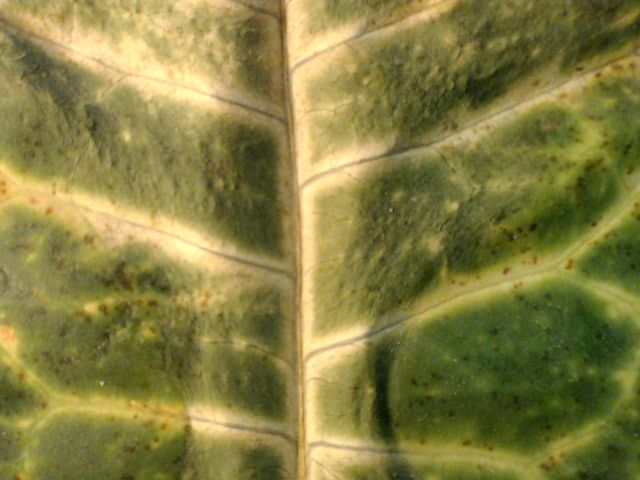

In [5]:
try:
  filename = take_photo()
  print('The captured photo')
  
  display(Image(filename))
except Exception as err:
  print(str(err))


# Run DLA code and GROW

[Errno 2] No such file or directory: 'DLA'
/content/DLA/DLA


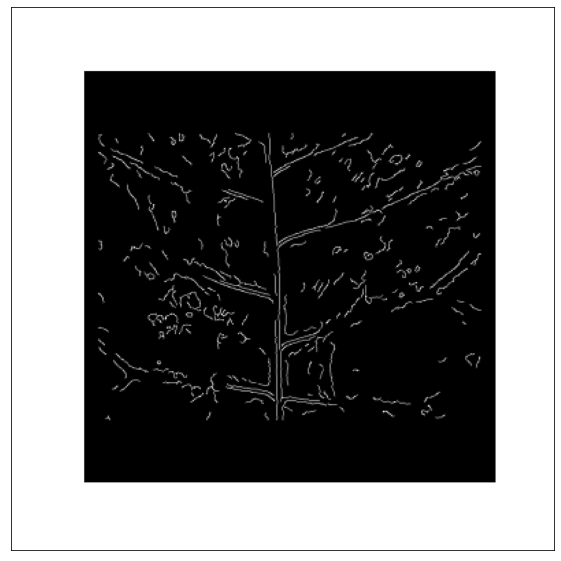

In [14]:
%cd DLA
from dla import BaseDLA, DLA_PathHist
from utils import get_centralized_init, get_binary_centered_mask, save_image, read_image, imshow

# Mask pre-processing parameters
MASK_SIZE=280
OUT_SIZE=300
BLUR_KERNEL=9
THRESHOLD1=40
THRESHOLD2=80
MIN_SIZE_BLOB=40

# LDA grow parameters
MAX_PARTICLES = 5000
RADIUS_SIZE = 30

# Display parameters
FIGURE_SIZE = 10

# Save parameters
DPI = 300
COLOR_MAP = 'gray' # ['gray', 'bw', 'jet]
SAVE_FRAME_INTERVAL = 10


# Create initial mask from input image
init = get_binary_centered_mask(file='/content/photo.jpg',
                                mask_size=MASK_SIZE,
                                out_size=OUT_SIZE,
                                blur_kernel=BLUR_KERNEL,
                                threshold1=THRESHOLD1,
                                threshold2=THRESHOLD2,
                                min_size_blob=MIN_SIZE_BLOB)
save_image(init, '/content', 'init_mask', dpi=DPI, cmap='gray')
init_mask = read_image('/content/init_mask.jpg')

plt.rcParams['figure.figsize'] = [FIGURE_SIZE, FIGURE_SIZE]
imshow(init_mask, COLOR_MAP)

Logged 876 particles (out of 5000)
Logged 1754 particles (out of 5000)
Logged 2643 particles (out of 5000)
Logged 3520 particles (out of 5000)
Logged 4424 particles (out of 5000)
Finish grow


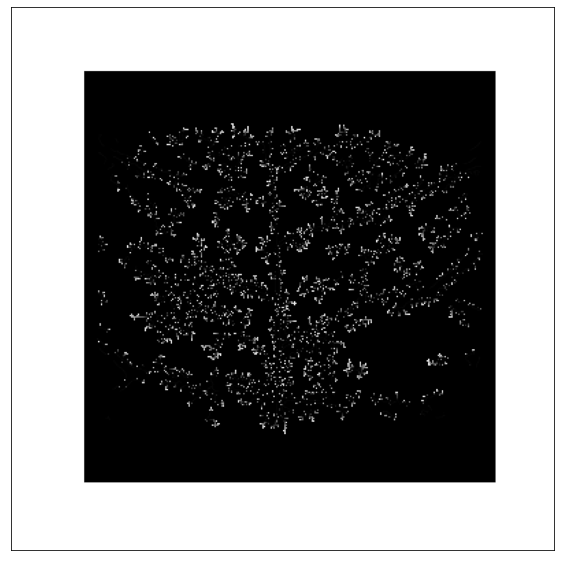

In [15]:
# Grow DLA over the initial image
dla = BaseDLA(init,
              max_particles=MAX_PARTICLES,
              radius=RADIUS_SIZE,
              log_level=3,
              random_walk_policy='radius')
dla.grow()

# Save and view final image
dla.save_image(dir='/content', name='final_image',
               cmap=COLOR_MAP, dpi=DPI)
plt.rcParams['figure.figsize'] = [FIGURE_SIZE, FIGURE_SIZE]
imshow(read_image('/content/final_image.jpg'), COLOR_MAP)

In [ ]:
%matplotlib inline
from IPython.display import Image

# Save and view final movie
dla.save_video(dir='/content', fname='final_movie',
               cmap=COLOR_MAP, dpi=DPI, save_pic_interval=SAVE_FRAME_INTERVAL)
Image(open('/content/final_movie.gif','rb').read())